# Simple Neural Network Model with different outputs

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with various constraint options for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model
from cvxpy.error import SolverError

In [3]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [5]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 6, 27)

In [6]:
val_split = int(0.7 * x.shape[0])
test_split = int(0.8 * x.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
x_train = x[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
x_val = x[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
x_test = x[test_split:]

## Defining models for different outputs

Tight constraints for weights between 0.7 * benchmark_weight and 1.5 * benchmark_weights

In [7]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except SolverError:
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / \
            summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y_tight_constraints = np.array(y)

y_train_tight_constraints = y_tight_constraints[:val_split]
y_val_tight_constraints = y_tight_constraints[val_split:test_split]
y_test_tight_constraints = y_tight_constraints[test_split:]

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.8686 - val_loss: 2.6270 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5518 - val_loss: 2.3309 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2622 - val_loss: 2.0624 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0002 - val_loss: 1.8206 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7650 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5538 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3656 - val_loss: 1.2386 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1982 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0500 - val_loss: 0.9505 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

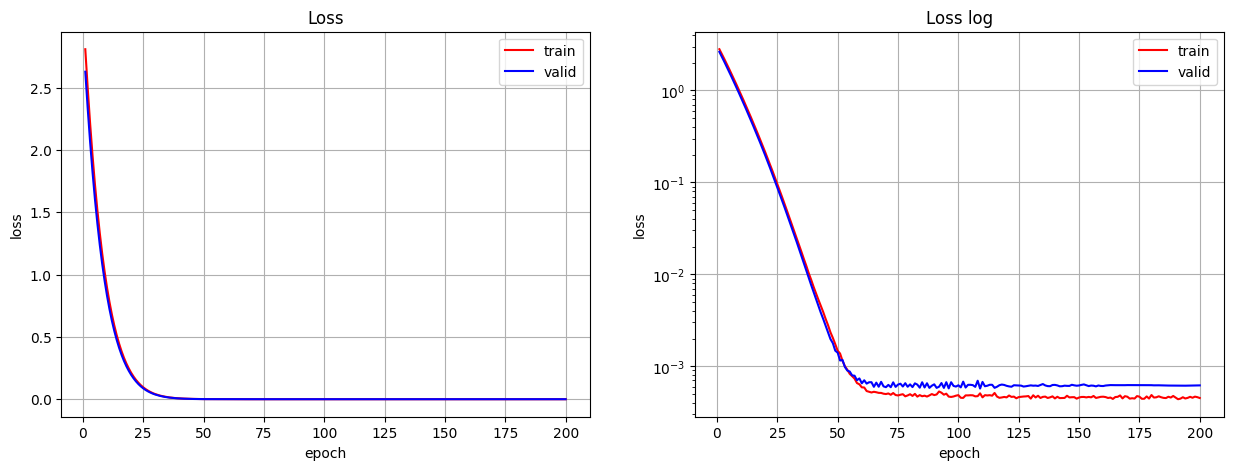

In [8]:
model_dnn_tight_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_tight_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_tight_constraints, 
                         x_train, y_train_tight_constraints,
                         x_val, y_val_tight_constraints, 
                         x_test, y_test_tight_constraints)

Normal constraints for weights between 0.5 * benchmark_weight and 2 * benchmark_weights

In [9]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y_normal_constraints = np.array(y)

y_train_normal_constraints = y_normal_constraints[:val_split]
y_val_normal_constraints = y_normal_constraints[val_split:test_split]
y_test_normal_constraints = y_normal_constraints[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0460 - val_loss: 2.7940 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7165 - val_loss: 2.4854 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4144 - val_loss: 2.2042 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1391 - val_loss: 1.9499 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8911 - val_loss: 1.7213 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6683 - val_loss: 1.5166 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4693 - val_loss: 1.3339 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2911 - val_loss: 1.1712 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1334 - val_loss: 1.0267 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

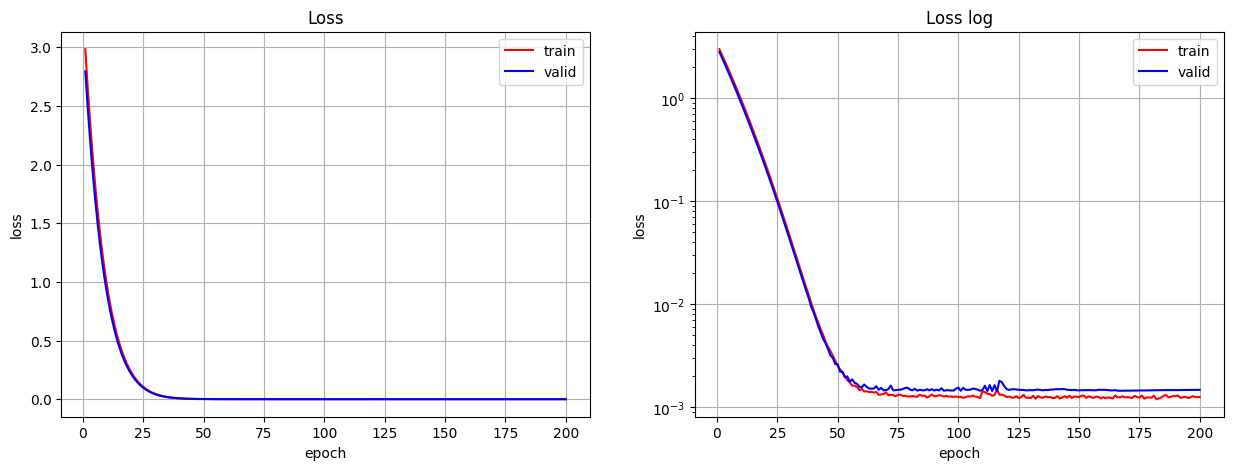

In [10]:
model_dnn_normal_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_normal_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_normal_constraints, 
                         x_train, y_train_normal_constraints,
                         x_val, y_val_normal_constraints, 
                         x_test, y_test_normal_constraints)

Loose constraints for weights between 0.3 * benchmark_weight and 3 * benchmark_weights

In [11]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])
        
    y.append(optimal_portfolio.values)

y_loose_constraints = np.array(y)

y_train_loose_constraints = y_loose_constraints[:val_split]
y_val_loose_constraints = y_loose_constraints[val_split:test_split]
y_test_loose_constraints = y_loose_constraints[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
y_train_loose_constraints.shape

(201, 27)

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8454 - val_loss: 2.6039 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5313 - val_loss: 2.3094 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2441 - val_loss: 2.0426 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9836 - val_loss: 1.8025 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7501 - val_loss: 1.5876 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5408 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3540 - val_loss: 1.2256 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1884 - val_loss: 1.0744 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0409 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

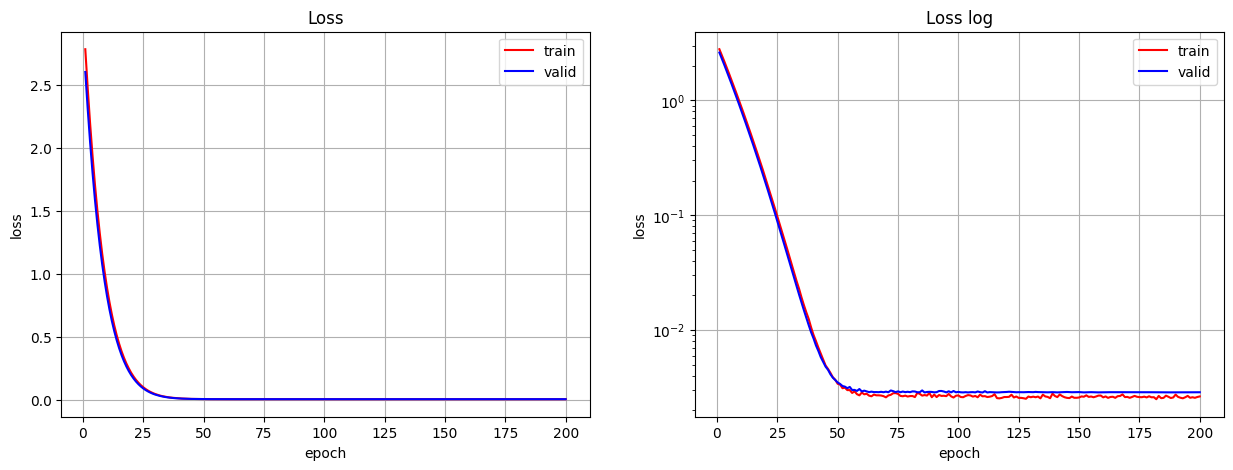

In [13]:
model_dnn_loose_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_loose_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_loose_constraints,
                         x_train, y_train_loose_constraints,
                         x_val, y_val_loose_constraints,
                         x_test, y_test_loose_constraints)

## Backtesting

In [24]:
from helper_functions import calculate_returns_for_model, calculate_metrics, calculate_returns_for_predictions

In [16]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [17]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [18]:
(total_ret_tight, cum_total_ret_tight) = calculate_returns_for_model(
    model_dnn_tight_constraints, x_test, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [19]:
(total_ret_normal, cum_total_ret_normal) = calculate_returns_for_model(
    model_dnn_normal_constraints, x_test, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
(total_ret_loose, cum_total_ret_loose) = calculate_returns_for_model(
    model_dnn_loose_constraints, x_test, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 


In [39]:
predictions_tight = model_dnn_tight_constraints.predict(x_test)
predictions_restricted = data_provider.apply_tight_contraints(predictions_tight)

total_returns_applied_restrictions, cum_total_returns_applied_restrictions = calculate_returns_for_predictions(
        predictions_restricted, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


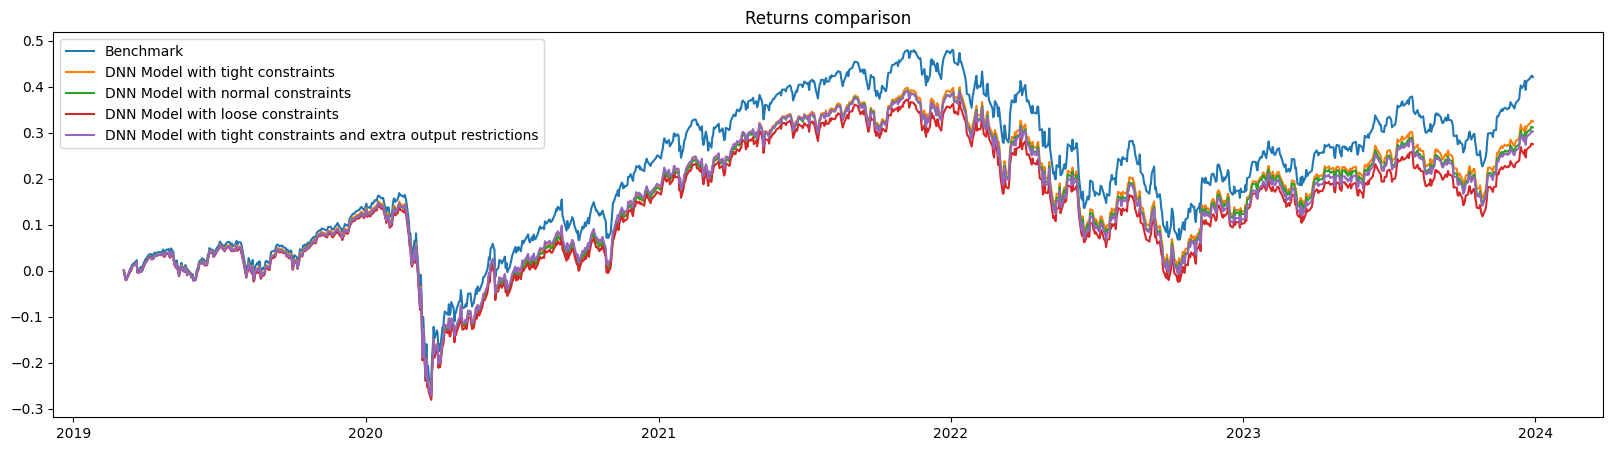

In [40]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_ret_tight, label='DNN Model with tight constraints')
plt.plot(cum_total_ret_normal, label='DNN Model with normal constraints')
plt.plot(cum_total_ret_loose, label='DNN Model with loose constraints')
plt.plot(cum_total_returns_applied_restrictions, label='DNN Model with tight constraints and extra output restrictions')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [41]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret_tight, df_results, 'DNN Model with tight constraint')
calculate_metrics(total_ret_normal, df_results, 'DNN Model with normal constraint')
calculate_metrics(total_ret_loose, df_results, 'DNN Model with loose constraint')
calculate_metrics(total_returns_applied_restrictions, df_results, 'DNN Model with tight constraint and extra output restrictions')

df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model with tight constraint,0.060671,0.20146,0.301158
DNN Model with normal constraint,0.058477,0.200554,0.291578
DNN Model with loose constraint,0.052354,0.199342,0.262633
DNN Model with tight constraint and extra output restrictions,0.057019,0.201545,0.28291
